 # Downloading Large Scale Data

This section will teach you how to interact with the Neuropixels dataset, specifically how to download experimental sessions, return procesed data, and subset your data to contain only brain regions you are interested in. 

We will first need to import the `EcephysProjectCache` from the Allen SDK and create an instance of the class. The class is used to download the metadata and data for all sessions in the Neuropixels dataset. For the full list of methods, please visit the <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_project_cache.html'> original documentation</a>.

Below we will execute `get_session_table()` on our `EcephysProjectCache` object which will return a dataframe with metadata on each session. 

In [17]:
# Import necessary packages 
import numpy as np 
import pandas as pd 
import scipy as sp
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import packages necessary to plot behavior
import allensdk.brain_observatory.ecephys.visualization as ecvis
from allensdk.brain_observatory.visualization import plot_running_speed

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Assign where data will be stored
manifest_path = 'manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path)

# Return all sessions available in this dataset
sessions = cache.get_session_table()
print('Total number of sessions: ' + str(len(sessions)))
sessions.head()

Total number of sessions: 58


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


A few columns that we may want to pay attention to for future analysis are the `full_genotype`, `unit_count`, and `ecephys_structure_acronyms`. 

In this dataset, a `unit` referes to an individual neuron that was recorded in the session. The `unit_count` refers to the total number of neurons recorded in a particluar sesssion. As mentioned in the chapter introduction, three different genotypes were used alongside the wildtype for these experiments. You can find the genotype under `full_genotype`. Lastly, you can find what structures the data in a session was collected from under `ecephys_structure_acronyms`.

Below we will return the follwoing information on our sessions: 
- how many sessions per genotype
- the average number of units recorded per session
- what brain structures were used in our sessions

In [3]:
genotypes = sessions['full_genotype'].value_counts()

avg_units = sessions['unit_count'].mean()

brain_areas = []

for idx,structure in sessions.iterrows():
    for i in structure['ecephys_structure_acronyms']:
        if i not in brain_areas:
            brain_areas.append(i)
        else:
            continue

print('Genotype Count:')
print(genotypes)

print('\n Average Units:')
print(avg_units)

print('\n All brain areas:')
print(brain_areas)

Genotype Count:
wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

 Average Units:
689.8275862068965

 All brain areas:
['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT', 'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL', 'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS', 'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL', 'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP', 'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'COAa', 'RT', 'SCop', 'SCsg', 'SCzo', 'COApm', 'OLF', 'BMAa']


Let's say we only want sessions where the data has recordings from CA1. We can do the following to create a session list that we want.

In [4]:
# Create a session list based on some criteria

session_list = []

for idx,structure_list in enumerate(sessions['ecephys_structure_acronyms']):
    if 'CA1' in structure_list:
        session_list.append(sessions.index[idx])   
        
print('There are '+str(len(session_list))+' sessions that meet this criteria:')
print(session_list)

There are 52 sessions that meet this criteria:
[715093703, 719161530, 721123822, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 761418226, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


## Single Session

Now, we can use the session list to get the data we want. Unfortunately, it looks like we can only extract one experiment as a time, so if you want to do this for multiple experiments, you'll need to loop over the `get_session_data` method for your entire session_list. For example, your workflow might be:

1. Extract one session.
2. Look for units recorded from your brain region of interest in that session.
3. Extract whatever metric you're interested in (e.g., firing rate).
4. Append those values to a list of firing rates.
5. Loop back around to the next session.

The `get_session_data` downloads the `NWB` data file of our experiment session and returns a session object that contains data and metadata for a single session. For a full list of methods and attributes for an ecephys session object, please visit the <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_session.html'> original dcumentation</a>. Here, we'll just take one session as an example.

**Note**: The session files are very large files that will take some time to download depending on your connection speed. It is important that you do not stop the download as the cell is running becasue this will truncate the file and you will not be able to work with the data. The cell block below creates a new instance of `EcephysProjectCache` with a larger `timeout` value to ensure enough time is allowed for the file to download. 

In [5]:
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

In [6]:
# Download our session data 
session = cache.get_session_data(session_list[1])
print('Session downloaded.')

Session downloaded.


## Units

Now that we have downloaded the single session file, we can begin to explore our `EcephysSession` object. The `units` property of our session object returns a dataframe that contains the recorded activity of sorted neurons from a mouse brain. There are many metrics stored within `units` that can be used in your potential analyses. Some key metrics include:

- **firing rate**: mean spike rate during the entire session
- **presence ratio**: fraction of session when spikes are present
- **ISI violations**: rate of refractory period violations
- **peak_channel_id**: channel in which peak-to-trough amplitutde is maximized
- **d'**: classification accuracy based on LDA
- **SNR**: signal to noise ratio
- **Maximum drift**: Maximum change in spike depth during recording
- **Cumulative drift**: Cumulative change in spike depth during recording

For a full list of methods and attributes that can be called on an `EcephysSession` object, please see <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_session.html'> here</a>.

In [7]:
# Return units dataframe
units_df = session.units
units_df.head()

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,waveform_recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950916730,0.315913,0,850252273,421.99,0.010911,2.408535,-0.072013,115.066739,0.001010,NaN,...,215.0,APN,8369.0,3658.0,6985.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916822,0.233501,7,850252319,294.57,0.000025,3.769478,-0.212549,160.983322,0.000000,0.115187,...,215.0,APN,8288.0,3464.0,7039.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916845,0.192295,9,850252323,270.88,0.023245,3.087942,-0.216281,77.035531,0.002380,0.170339,...,215.0,APN,8281.0,3448.0,7044.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916856,0.233501,10,850252325,219.19,0.011552,2.743504,-0.087931,291.708582,0.047256,0.141643,...,215.0,APN,8277.0,3440.0,7046.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916892,0.343384,13,850252329,558.87,0.029890,2.428990,-0.005812,41.639547,0.000338,0.180152,...,215.0,APN,8270.0,3424.0,7051.0,probeA,See electrode locations,29999.967418,1249.998642,True


To ensure that the recordings we use in our analysis are all of good quality, we will filter the data according to the signal-to-noise ratio (`snr`) and the `ISI_Violations` of our neurons. Below we will plot the distributions of both.

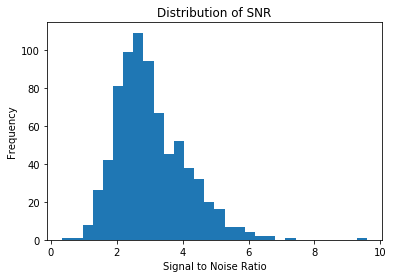

In [10]:
# Signal to noise distribution
col_1 = 'snr'
plt.hist(units_df['snr'], bins=30)
plt.title('Distribution of SNR')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('Frequency')
plt.show()

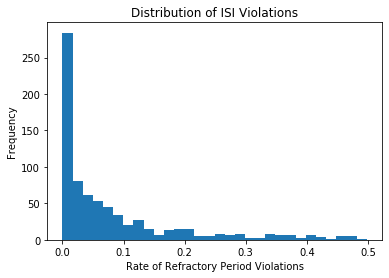

In [11]:
# ISI distribution 
col_2 = 'isi_violations'
plt.hist(units_df[col_2], bins=30)
plt.title('Distribution of ISI Violations')
plt.xlabel('Rate of Refractory Period Violations')
plt.ylabel('Frequency')
plt.show()

For the purposes of this tutorial, we will use `snr` values greater than 2 and `ISI_violation` values less than 0.1, define our good quality units. 

In [12]:
# Create dataframe with our conditions of interest
good_snr = units_df[units_df['snr']>2]
good_units_df = good_snr[good_snr['isi_violations']<0.1]


print('Number of Recordings with good SNR and Low ISI:')
print(len(good_units_df))
good_units_df.head()

Number of Recordings with good SNR and Low ISI:
488


,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,waveform_recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950916730,0.315913,0,850252273,421.99,0.010911,2.408535,-0.072013,115.066739,0.001010,NaN,...,215.0,APN,8369.0,3658.0,6985.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916822,0.233501,7,850252319,294.57,0.000025,3.769478,-0.212549,160.983322,0.000000,0.115187,...,215.0,APN,8288.0,3464.0,7039.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916856,0.233501,10,850252325,219.19,0.011552,2.743504,-0.087931,291.708582,0.047256,0.141643,...,215.0,APN,8277.0,3440.0,7046.0,probeA,See electrode locations,29999.967418,1249.998642,True
950917034,0.467002,24,850252351,154.34,0.003052,2.084643,-0.059217,179.310426,0.013169,0.102770,...,215.0,APN,8229.0,3331.0,7079.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916996,0.192295,21,850252349,184.14,0.003787,2.805553,-0.221815,68.033790,0.003977,0.054381,...,215.0,APN,8232.0,3339.0,7077.0,probeA,See electrode locations,29999.967418,1249.998642,True


Just like we did before in our sessions dataframe, we can return the brain structures that our session's data was recorded from as well as how many neurons were recorded per brain area. 

In [13]:
col = 'ecephys_structure_acronym'

print('Available Brain Structures:')
print(good_units_df[col].unique())
print('\n Brain Structure Frequency:')
print(good_units_df[col].value_counts())

Available Brain Structures:
['APN' 'DG' 'CA1' 'VISam' 'TH' 'Eth' 'POL' 'LP' 'VISpm' 'NOT' 'SUB' 'VISp'
 'grey' 'VL' 'CA3' 'VISl' 'PO' 'VPM' 'LGd' 'VISal' 'VISrl']

 Brain Structure Frequency:
APN      134
CA1       57
LGd       51
POL       39
VISp      35
SUB       30
VISl      28
VISam     20
LP        19
VPM       18
VISpm     13
NOT        9
CA3        8
TH         7
DG         7
PO         5
VISal      2
VL         2
grey       2
Eth        1
VISrl      1
Name: ecephys_structure_acronym, dtype: int64


## Waveforms 

Each session contains a dictionary of mean waveforms for all the units recorded in that session. They are stored inside a xarray DataArray where the `unit_id` are mapped to the mean spike waveform values. The dimensions of the DataArrays are `channel` and `time` which are recorded in microvolts and seconds, respectivley. For more information on `xarray.DataArray`, please visit, <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html'> here</a>.

To access the mean spike waveforms for all units in a session, use the attribute `mean_waveforms` on your `EcephysSession` object. 

In [14]:
all_mean_waveforms = session.mean_waveforms
print('Total number of waveforms:')
print(len(all_mean_waveforms))

Total number of waveforms:
755


We can plot the mean waveforms of our units with the method `plot_mean_waveforms` from the ecephys visualization package. The method uses the `mean_waveforms` dictionary, `unit_id`'s, and `peak_channel_id`'s as arguments. For more information on this method, visit <a href = 'https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.ecephys.visualization.html'> here</a>.

Below we will compare mean waveforms from different brain areas. We will be looking at one wavefrom from the `CA1`, `LP`, `DG`, `VISp`. We first need to create a list of unit_id's for the waveforms we are interested in. 

In [15]:
# Assign Unit IDs of different brain areas of interest
CA1_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'CA1'].index
LP_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'LP'].index
DG_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'DG'].index
VISp_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index

# Return first entry of our brain areas of interst
first_CA1_units_ids = CA1_unit_ids[0]
first_LP_units_ids = LP_unit_ids[0]
first_DG_units_ids = DG_unit_ids[1]
first_VISp_units_ids = VISp_unit_ids[0]
uois_ids = [first_CA1_units_ids, first_LP_units_ids, first_DG_units_ids, first_VISp_units_ids]

# Return dataframe
uois_df = good_units_df.loc[uois_ids]

uois_df

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,waveform_recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950918424,0.288442,124,850252701,138.64,0.020835,2.185120,-0.039858,90.797157,0.001406,0.102849,...,382.0,CA1,7767.0,1620.0,7511.0,probeA,See electrode locations,29999.967418,1249.998642,True
950924138,0.302178,221,850249435,132.03,0.000049,4.994113,-0.187781,124.487692,0.000000,0.218848,...,218.0,LP,7918.0,2983.0,7322.0,probeB,See electrode locations,29999.918880,1249.996620,True
950925274,0.549414,302,850249617,79.80,0.000065,3.726180,-0.099074,215.917914,0.000000,0.206406,...,726.0,DG,7895.0,2110.0,7360.0,probeB,See electrode locations,29999.918880,1249.996620,True
950934565,0.879062,336,850251321,139.52,0.000468,2.959099,-0.025951,66.252958,0.000239,0.171097,...,385.0,VISp,8451.0,1184.0,7704.0,probeC,See electrode locations,29999.997521,1249.999897,True


Using the `unit_ids`, we can create our own dictionary that maps our ids of interest to the `mean_waveforms` array,

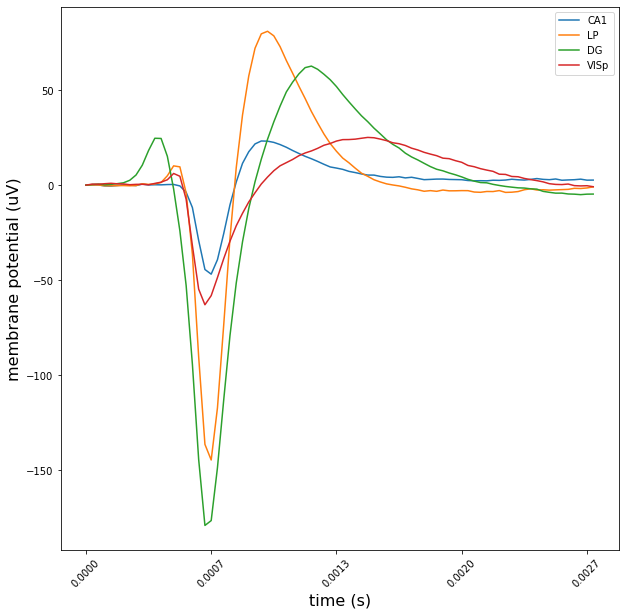

In [22]:
# Create dictionary of waveforms that only include units of interest
waveforms_oi = {}
for ids in uois_ids:
    waveforms_oi[ids] = all_mean_waveforms[ids]

# Create dictionary of peak channels that only include units of interest
peak_channels_oi = {}
for ids in uois_ids:
    peak_channels_oi[ids] = good_units_df.loc[ids, 'peak_channel_id']

# Plot mean waveforms
fig = ecvis.plot_mean_waveforms(waveforms_oi, uois_ids, peak_channels_oi)
legend_list = list(uois_df['ecephys_structure_acronym'] )
plt.legend(legend_list)


plt.show()